In [6]:
import joblib
# load the trained model and scaler
model = joblib.load('model.pkl')
scaler = joblib.load('scaler.pkl')
model_cpu = joblib.load('model_cpu.pkl')
scaler_cpu = joblib.load('scaler_cpu.pkl')

In [7]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


class PIControllerMatchingC:
    def __init__(self, kp, ki, kW,
                 out_limit_low, out_limit_high,
                 int_limit_low, int_limit_high,
                 setpoint):
        self.kP = kp
        self.kI = ki
        self.kW = kW

        self.out_limit_low = out_limit_low
        self.out_limit_high = out_limit_high

        self.int_limit_low = int_limit_low
        self.int_limit_high = int_limit_high

        self.setpoint = setpoint

        self.errInt = 0.0
        self.outVal = 0.0

    def reset(self, setpoint=None):
        if setpoint is not None:
            self.setpoint = float(setpoint)
        self.errInt = 0.0
        self.outVal = 0.0

    def update(self, feedback):
        # firmware style: err = feedback - reference
        errNew = feedback - self.setpoint

        # integral accumulation (no dt)
        self.errInt += errNew

        out_unclipped = (self.kP * errNew) + (self.kI * self.errInt)

        # clamp + anti-windup
        if out_unclipped > self.out_limit_high:
            self.outVal = self.out_limit_high
            excess = out_unclipped - self.outVal
            self.errInt -= self.kW * excess

        elif out_unclipped < self.out_limit_low:
            self.outVal = self.out_limit_low
            excess = out_unclipped - self.outVal
            self.errInt -= self.kW * excess

        else:
            self.outVal = out_unclipped

        # integral limits
        self.errInt = max(self.int_limit_low, min(self.errInt, self.int_limit_high))

        return self.outVal

In [8]:
class TecThermalEnv(gym.Env):
    """
    Gymnasium env for a TEC-controlled thermal plant, using XGBoost next-step prediction.

    Action (Option A):
        action[0] = TEC current in Amps, normalized to [-1, +1] then scaled to [0, 8].

    Observation:
        [T_aux, T_cpu, setpoint, error, current,
         current_lag1, current_lag2, current_lag3,
         current_sq, sq_lag1, sq_lag2, sq_lag3,
         step_fraction]
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        temp_model,
        temp_scaler,
        cpu_model=None,
        cpu_scaler=None,
        max_steps=300,
        current_min=0.0,
        current_max=8.0,
        noise_std=0.7,
        use_noise=True,
        setpoint_range=(28.0, 45.0),
        init_temp_range=(28.0, 45.0),
        init_cpu_temp_range=(40.0, 60.0),
        render_mode=None,
    ):
        super().__init__()

        self.temp_model = temp_model
        self.temp_scaler = temp_scaler

        self.cpu_model = cpu_model
        self.cpu_scaler = cpu_scaler

        self.max_steps = int(max_steps)
        self.current_min = float(current_min)
        self.current_max = float(current_max)

        self.noise_std = float(noise_std)
        self.use_noise = bool(use_noise)

        self.setpoint_range = tuple(setpoint_range)
        self.init_temp_range = tuple(init_temp_range)
        self.init_cpu_temp_range = tuple(init_cpu_temp_range)

        self.render_mode = render_mode

        # Action: 1D normalized current in [-1, 1]
        self.action_space = spaces.Box(
            low=np.array([-1.0], dtype=np.float32),
            high=np.array([+1.0], dtype=np.float32),
            dtype=np.float32
        )

        # Observation: define wide but finite bounds
        # (you can tighten these once you know your operating envelope)
        obs_low = np.array(
            [0, 0, 0, -100, self.current_min,
             self.current_min, self.current_min, self.current_min,
             0, 0, 0, 0,
             0],
            dtype=np.float32
        )
        obs_high = np.array(
            [120, 120, 120, 100, self.current_max,
             self.current_max, self.current_max, self.current_max,
             self.current_max**2, self.current_max**2, self.current_max**2, self.current_max**2,
             1],
            dtype=np.float32
        )

        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # internal state
        self._rng = np.random.default_rng()
        self.reset(seed=None)

    def _scale_action_to_current(self, a_norm: float) -> float:
        # a_norm in [-1, 1] -> [current_min, current_max]
        a = float(np.clip(a_norm, -1.0, 1.0))
        return self.current_min + (a + 1.0) * 0.5 * (self.current_max - self.current_min)

    def _build_features(self, T_aux, T_cpu, current, lag1, lag2, lag3):
        # Match your feature layout:
        # [current_temp, current**2, current, cpu_temp_next, lag1, lag2, lag3, sq1, sq2, sq3]
        sq = current**2
        sq1, sq2, sq3 = lag1**2, lag2**2, lag3**2
        return np.array([[T_aux, sq, current, T_cpu, lag1, lag2, lag3, sq1, sq2, sq3]], dtype=np.float32)

    def _get_obs(self):
        T_aux = self.T_aux
        T_cpu = self.T_cpu
        sp = self.setpoint
        err = sp - T_aux
        cur = self.currents[-1]
        lag1, lag2, lag3 = self.currents[-1], self.currents[-2], self.currents[-3]
        cur_sq = cur**2
        sq1, sq2, sq3 = lag1**2, lag2**2, lag3**2
        step_frac = self.step_idx / max(1, self.max_steps)

        obs = np.array([
            T_aux, T_cpu, sp, err, cur,
            lag1, lag2, lag3,
            cur_sq, sq1, sq2, sq3,
            step_frac
        ], dtype=np.float32)
        return obs

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self._rng = np.random.default_rng(seed)

        # randomize initial conditions (or override via options)
        self.setpoint = float(self._rng.uniform(*self.setpoint_range))
        self.T_aux = float(self._rng.uniform(*self.init_temp_range))
        self.T_cpu = float(self._rng.uniform(*self.init_cpu_temp_range))

        if options is not None:
            if "setpoint" in options: self.setpoint = float(options["setpoint"])
            if "T_aux" in options: self.T_aux = float(options["T_aux"])
            if "T_cpu" in options: self.T_cpu = float(options["T_cpu"])

        self.step_idx = 0

        # currents history for lags (initialize with zeros)
        self.currents = [0.0, 0.0, 0.0]  # lag3, lag2, lag1 style
        self.last_action_current = 0.0

        obs = self._get_obs()
        info = {"setpoint": self.setpoint}
        return obs, info

    def step(self, action):
        self.step_idx += 1

        # action -> current
        current = self._scale_action_to_current(float(action[0]))
        current = float(np.clip(current, self.current_min, self.current_max))

        # prepare lags
        lag1 = self.currents[-1]
        lag2 = self.currents[-2]
        lag3 = self.currents[-3]

        # optionally predict CPU temp next (if you have a cpu model)
        if self.cpu_model is not None and self.cpu_scaler is not None:
            cpu_feats = self._build_features(self.T_aux, self.T_cpu, current, lag1, lag2, lag3)
            cpu_next = float(self.cpu_model.predict(self.cpu_scaler.transform(cpu_feats))[0])
        else:
            # fallback: keep CPU temp the same (or implement your own heuristic)
            cpu_next = float(self.T_cpu)

        # predict AUX temp next
        feats = self._build_features(self.T_aux, cpu_next, current, lag1, lag2, lag3)
        T_next = float(self.temp_model.predict(self.temp_scaler.transform(feats))[0])

        if self.use_noise and self.noise_std > 0:
            T_next += float(self._rng.normal(0.0, self.noise_std))

        # update state and history
        self.T_aux = T_next
        self.T_cpu = cpu_next
        self.currents.append(current)
        self.last_action_current = current

        # compute reward
        err = self.setpoint - self.T_aux
        abs_err = abs(err)

        # penalties (tune these weights to taste)
        current_pen = 0.02 * (current / self.current_max)          # prefer smaller currents
        slew_pen = 0.05 * abs(current - lag1) / self.current_max   # prefer smoother changes

        reward = -abs_err - current_pen - slew_pen

        # termination logic
        terminated = False
        truncated = (self.step_idx >= self.max_steps)

        # safety termination: runaway or obviously invalid region
        if self.T_aux < -20 or self.T_aux > 150:
            terminated = True
            reward -= 50.0

        obs = self._get_obs()
        info = {
            "setpoint": self.setpoint,
            "error": err,
            "current": current,
            "T_aux": self.T_aux,
            "T_cpu": self.T_cpu,
        }

        return obs, reward, terminated, truncated, info

    def render(self):
        if self.render_mode != "human":
            return
        print(f"step={self.step_idx} T_aux={self.T_aux:.2f}C T_cpu={self.T_cpu:.2f}C "
              f"sp={self.setpoint:.2f} cur={self.currents[-1]:.2f}A")

    def close(self):
        pass


In [35]:
# -----------------------
# Optional: PI baseline loop using the SAME env plant
# -----------------------
def run_pi_baseline_episode(env: TecThermalEnv, kp=0.5, ki=0.025, setpoint=42.0, T0=30.0, cpu0=47.0):
    pi = PIControllerMatchingC(
        kp=kp, ki=ki, kW=0.0,
        out_limit_low=0.0, out_limit_high=8.0,
        int_limit_low=-200.0, int_limit_high=200.0,
        setpoint=setpoint,
    )
    obs, info = env.reset(options={"setpoint": setpoint, "T_aux": T0, "T_cpu": cpu0})
    pi.reset(setpoint=setpoint)

    temps, currents, rewards = [], [], []
    done = False

    while not done:
        T_aux = float(obs[0])
        cur = float(np.clip(pi.update(T_aux), 0.0, 8.0))
        # convert current -> normalized action for env
        a_norm = 2.0 * (cur - env.current_min) / (env.current_max - env.current_min) - 1.0
        obs, r, terminated, truncated, info = env.step(np.array([a_norm], dtype=np.float32))
        done = terminated or truncated

        temps.append(info["T_aux"])
        currents.append(info["current"])
        rewards.append(r)

    return np.array(temps), np.array(currents), np.array(rewards)

In [52]:
import joblib
import warnings
warnings.filterwarnings("ignore")

temp_model = joblib.load("model.pkl")
temp_scaler = joblib.load("scaler.pkl")

# Optional:
cpu_model = joblib.load("model_cpu.pkl")
cpu_scaler = joblib.load("scaler_cpu.pkl")

env = TecThermalEnv(
    temp_model=temp_model,
    temp_scaler=temp_scaler,
    cpu_model=cpu_model,      # or cpu_model
    cpu_scaler=cpu_scaler,     # or cpu_scaler
    max_steps=300,
    use_noise=True,
    noise_std=0.7,
)

# Run PI baseline
temps, currents, rewards = run_pi_baseline_episode(env, kp=0.5, ki=0.025, setpoint=42.0, T0=30.0, cpu0=47.0)
print("Final temp:", temps[-1], "Final current:", currents[-1], "Return:", rewards.sum())


Final temp: 41.44566705067639 Final current: 1.734011173248291 Return: -363.21771123550434


In [64]:
temps, currents, rewards = run_pi_baseline_episode(
    env,
    kp=0.5,
    ki=0.025,
    setpoint=42.0,
    T0=30.0,
    cpu0=47.0
)

print("Final temp:", temps[-1], "Return:", rewards.sum())


Final temp: 42.28034130970747 Return: -377.61740752282753


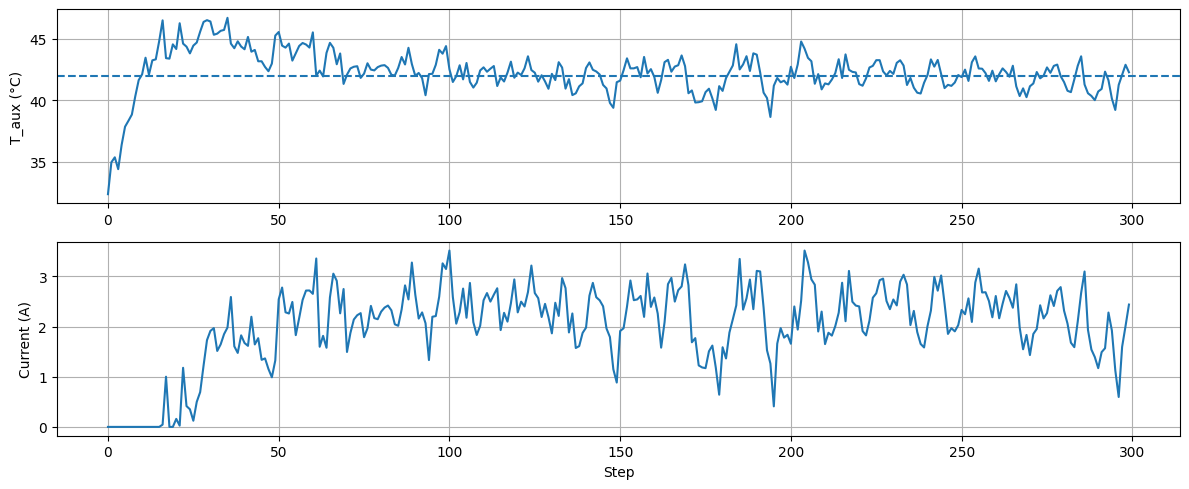

In [65]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(len(temps))

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(t, temps)
plt.axhline(42.0, linestyle="--")
plt.ylabel("T_aux (°C)")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t, currents)
plt.ylabel("Current (A)")
plt.xlabel("Step")
plt.grid(True)

plt.tight_layout()
plt.show()


In [67]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)  # catches common mistakes

model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    buffer_size=200_000,
    batch_size=256,
    gamma=0.99,
    train_freq=1,
)

model.learn(total_timesteps=200_000)
model.save("sac_tec_env")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 300       |
|    ep_rew_mean     | -2.25e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 47        |
|    time_elapsed    | 25        |
|    total_timesteps | 1200      |
| train/             |           |
|    actor_loss      | 37.8      |
|    critic_loss     | 3.85      |
|    ent_coef        | 0.736     |
|    ent_coef_loss   | -0.345    |
|    learning_rate   | 0.0003    |
|    n_updates       | 1099      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 300       |
|    ep_rew_mean     | -1.49e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 43        |
|    time_elapsed    | 54        |
|    total_timesteps | 2400   

In [75]:
import numpy as np

obs, info = env.reset(options={"setpoint": 42.0, "T_aux": 30.0, "T_cpu": 47.0})

temps, currents = [], []
for _ in range(300):
    action, _ = model.predict(obs, deterministic=True)
    obs, r, terminated, truncated, info = env.step(action)

    temps.append(info["T_aux"])
    currents.append(info["current"])

    if terminated or truncated:
        break

print("Final temp:", temps[-1], "Final current:", currents[-1])


Final temp: 41.56380766082877 Final current: 0.8189949989318848


In [77]:
import numpy as np

def run_episode_pi(env, kp, ki, setpoint, T0=30.0, cpu0=47.0, max_steps=None):
    pi = PIControllerMatchingC(
        kp=kp, ki=ki, kW=0.0,
        out_limit_low=0.0, out_limit_high=8.0,
        int_limit_low=-200.0, int_limit_high=200.0,
        setpoint=setpoint,
    )

    obs, info = env.reset(options={"setpoint": setpoint, "T_aux": T0, "T_cpu": cpu0})
    pi.reset(setpoint=setpoint)

    temps, currents, rewards, errors = [], [], [], []

    steps = env.max_steps if max_steps is None else int(max_steps)

    for _ in range(steps):
        T_aux = float(obs[0])

        cur = float(np.clip(pi.update(T_aux), 0.0, 8.0))
        a_norm = 2.0 * (cur - env.current_min) / (env.current_max - env.current_min) - 1.0
        action = np.array([a_norm], dtype=np.float32)

        obs, r, terminated, truncated, info = env.step(action)

        temps.append(info["T_aux"])
        currents.append(info["current"])
        rewards.append(r)
        # errors.append(info reminding? )  # don't rely on this unless you stored it in info

        if terminated or truncated:
            break

    temps = np.asarray(temps)
    currents = np.asarray(currents)
    errors = setpoint - temps
    return temps, currents, np.asarray(rewards), errors


def run_episode_rl(env, rl_model, setpoint, T0=30.0, cpu0=47.0, deterministic=True, max_steps=None):
    obs, info = env.reset(options={"setpoint": setpoint, "T_aux": T0, "T_cpu": cpu0})

    temps, currents, rewards = [], [], []

    steps = env.max_steps if max_steps is None else int(max_steps)

    for _ in range(steps):
        action, _ = rl_model.predict(obs, deterministic=deterministic)
        obs, r, terminated, truncated, info = env.step(action)

        temps.append(info["T_aux"])
        currents.append(info["current"])
        rewards.append(r)

        if terminated or truncated:
            break

    temps = np.asarray(temps)
    currents = np.asarray(currents)
    errors = setpoint - temps
    return temps, currents, np.asarray(rewards), errors


In [78]:
def compute_metrics(temps, currents, setpoint, tol=0.5):
    temps = np.asarray(temps)
    currents = np.asarray(currents)
    err = setpoint - temps
    abs_err = np.abs(err)

    iae = abs_err.sum()
    itae = (np.arange(len(abs_err)) * abs_err).sum()
    overshoot = max(0.0, temps.max() - setpoint)

    # settling time: first index after which we stay within ±tol
    settling = None
    within = abs_err <= tol
    for i in range(len(within)):
        if within[i] and within[i:].all():
            settling = i
            break

    energy = np.sum(currents**2)  # proxy for TEC power cost
    return {
        "IAE": float(iae),
        "ITAE": float(itae),
        "Overshoot": float(overshoot),
        "SettlingStep": None if settling is None else int(settling),
        "I2": float(energy),
        "FinalTemp": float(temps[-1]),
        "FinalError": float(err[-1]),
    }


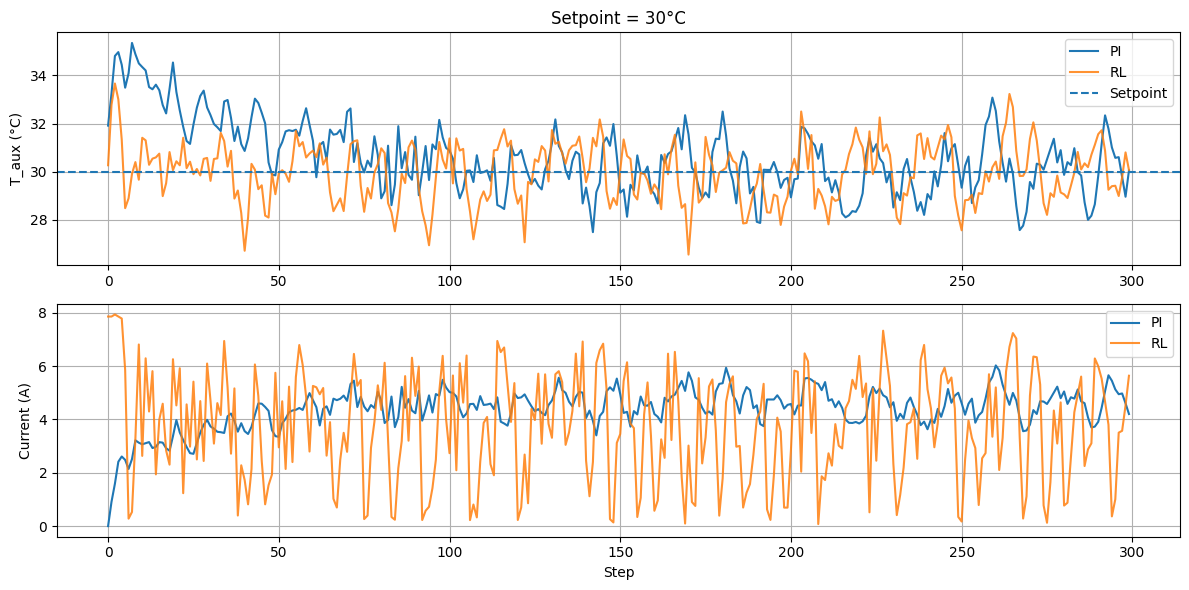

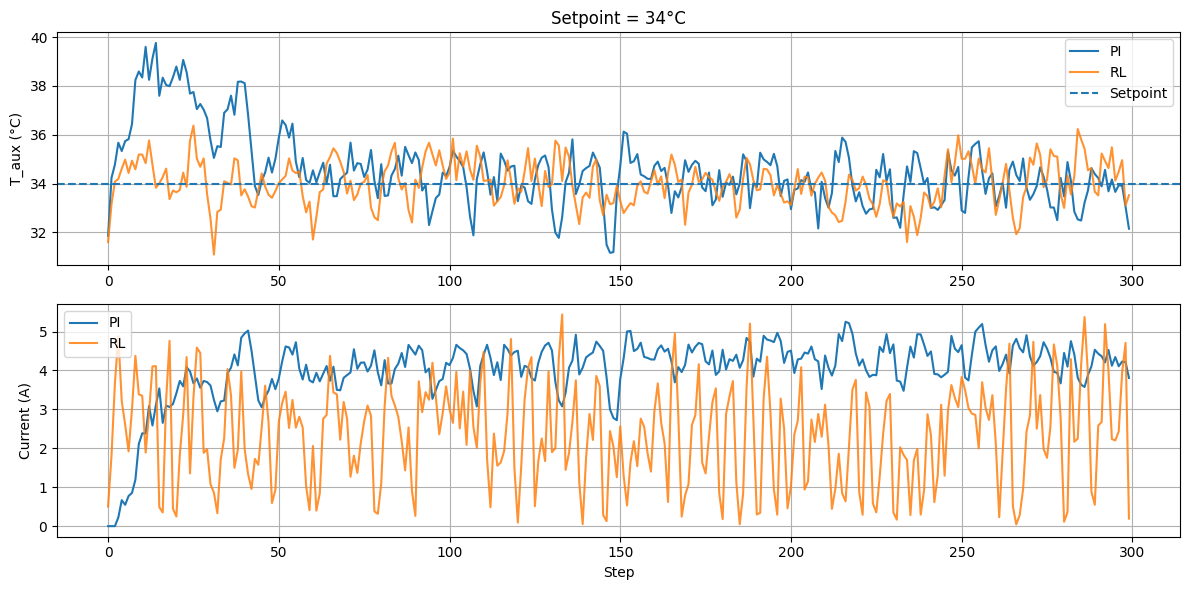

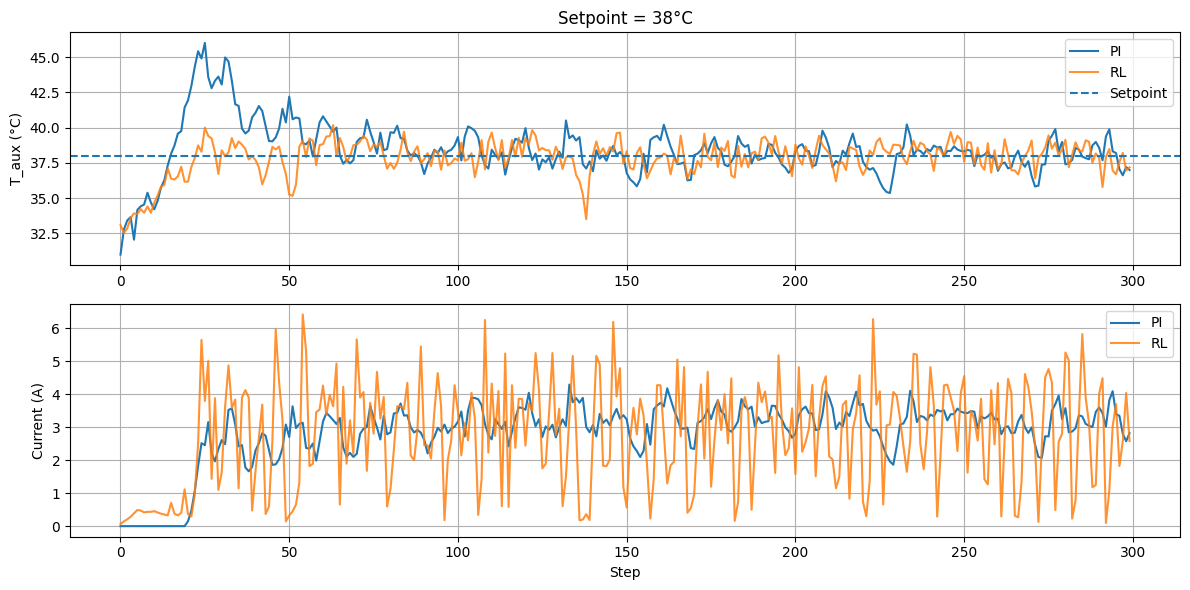

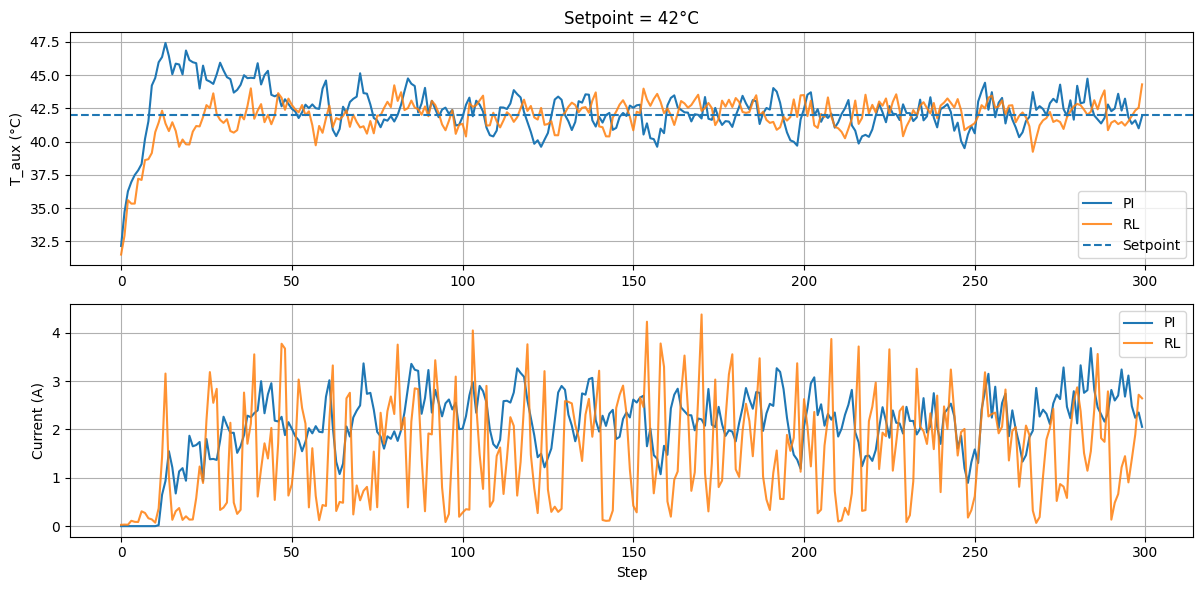

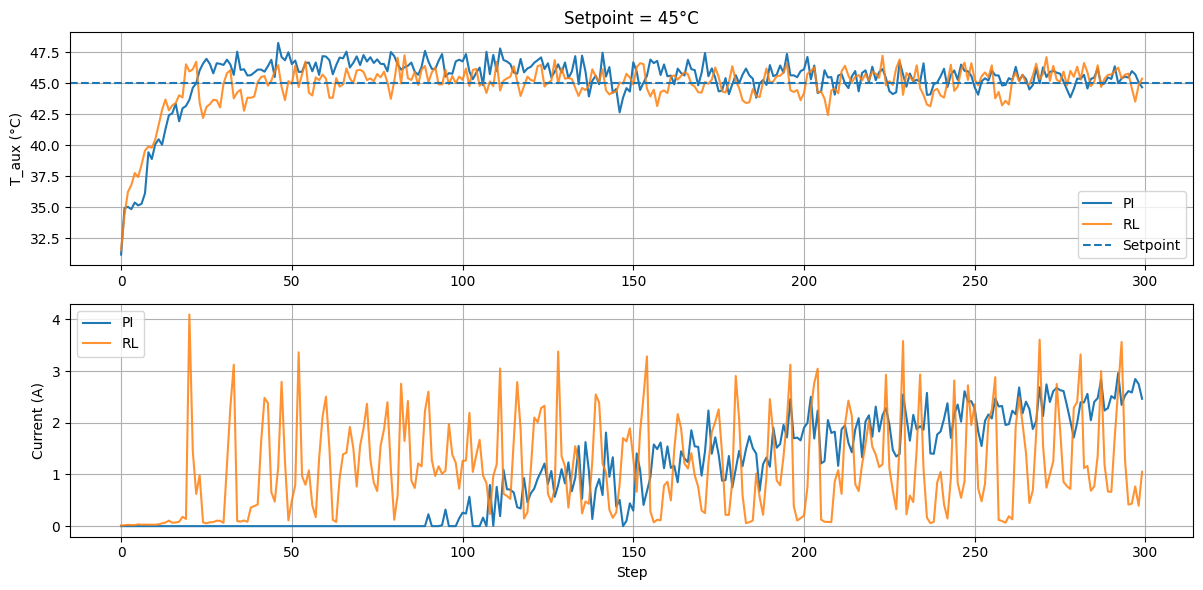

In [80]:
import matplotlib.pyplot as plt

setpoints = [30, 34, 38, 42, 45]
T0 = 30.0
cpu0 = 47.0

pi_kp, pi_ki = 0.45, 0.025   # use your tuned gains
results = []

for sp in setpoints:
    temps_pi, cur_pi, _, _ = run_episode_pi(env, pi_kp, pi_ki, setpoint=sp, T0=T0, cpu0=cpu0)
    temps_rl, cur_rl, _, _ = run_episode_rl(env, model, setpoint=sp, T0=T0, cpu0=cpu0)

    m_pi = compute_metrics(temps_pi, cur_pi, sp)
    m_rl = compute_metrics(temps_rl, cur_rl, sp)

    results.append((sp, m_pi, m_rl))

    t_pi = np.arange(len(temps_pi))
    t_rl = np.arange(len(temps_rl))

    plt.figure(figsize=(12, 6))

    # temperature
    plt.subplot(2, 1, 1)
    plt.plot(t_pi, temps_pi, label="PI")
    plt.plot(t_rl, temps_rl, label="RL", alpha=0.85)
    plt.axhline(sp, linestyle="--", label="Setpoint")
    plt.ylabel("T_aux (°C)")
    plt.title(f"Setpoint = {sp}°C")
    plt.grid(True)
    plt.legend()

    # current
    plt.subplot(2, 1, 2)
    plt.plot(t_pi, cur_pi, label="PI")
    plt.plot(t_rl, cur_rl, label="RL", alpha=0.85)
    plt.ylabel("Current (A)")
    plt.xlabel("Step")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


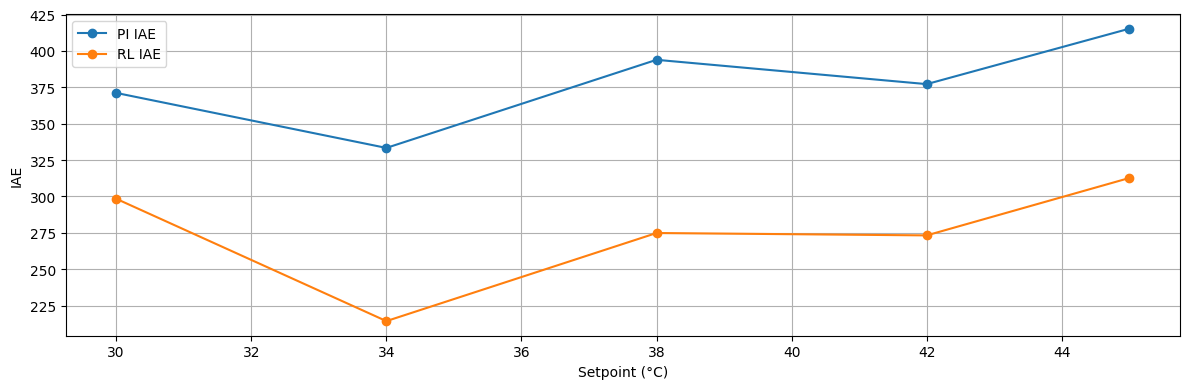

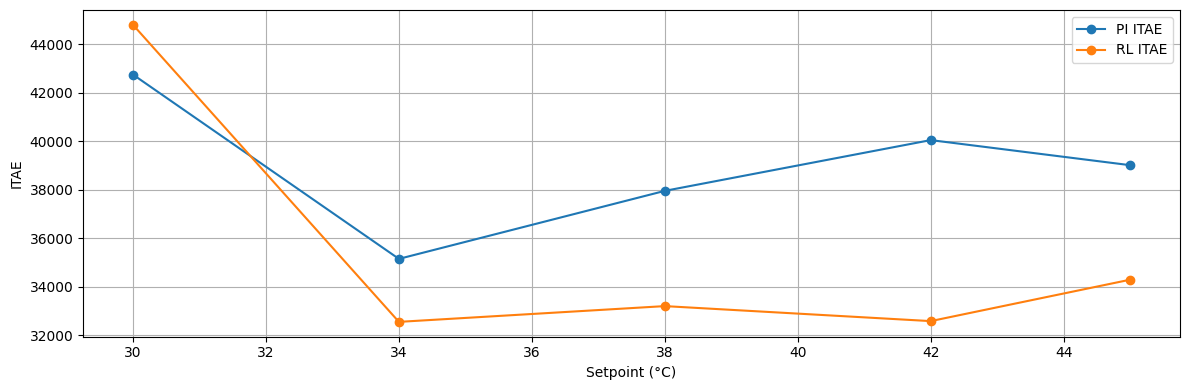

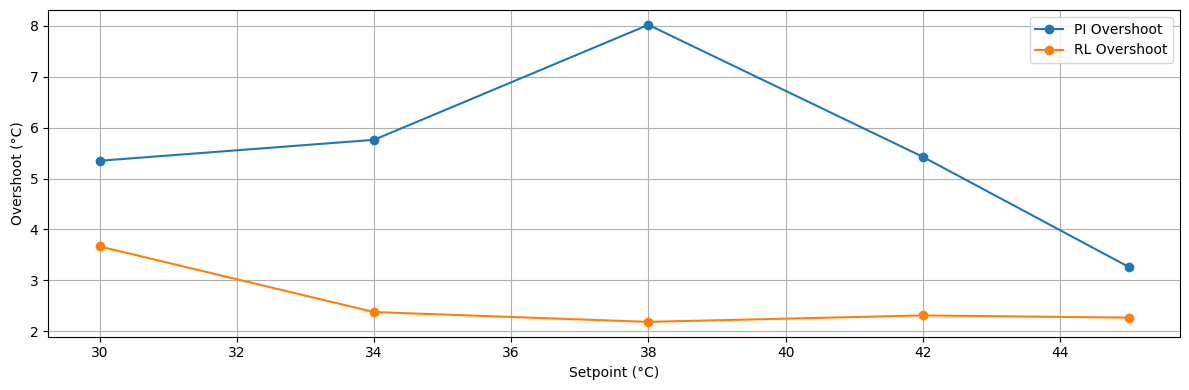

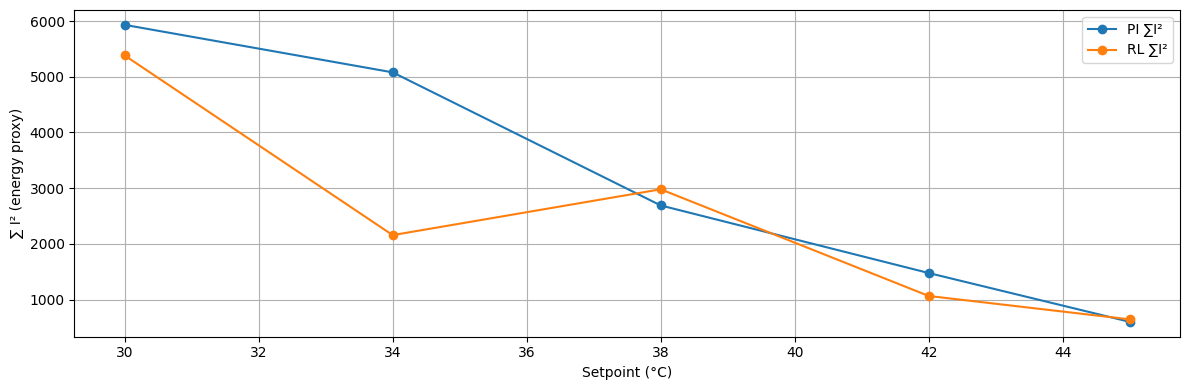

In [81]:
sps = [r[0] for r in results]
iae_pi = [r[1]["IAE"] for r in results]
iae_rl = [r[2]["IAE"] for r in results]

itae_pi = [r[1]["ITAE"] for r in results]
itae_rl = [r[2]["ITAE"] for r in results]

ov_pi = [r[1]["Overshoot"] for r in results]
ov_rl = [r[2]["Overshoot"] for r in results]

i2_pi = [r[1]["I2"] for r in results]
i2_rl = [r[2]["I2"] for r in results]

plt.figure(figsize=(12, 4))
plt.plot(sps, iae_pi, marker="o", label="PI IAE")
plt.plot(sps, iae_rl, marker="o", label="RL IAE")
plt.xlabel("Setpoint (°C)")
plt.ylabel("IAE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(sps, itae_pi, marker="o", label="PI ITAE")
plt.plot(sps, itae_rl, marker="o", label="RL ITAE")
plt.xlabel("Setpoint (°C)")
plt.ylabel("ITAE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(sps, ov_pi, marker="o", label="PI Overshoot")
plt.plot(sps, ov_rl, marker="o", label="RL Overshoot")
plt.xlabel("Setpoint (°C)")
plt.ylabel("Overshoot (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(sps, i2_pi, marker="o", label="PI ∑I²")
plt.plot(sps, i2_rl, marker="o", label="RL ∑I²")
plt.xlabel("Setpoint (°C)")
plt.ylabel("∑ I² (energy proxy)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [82]:
scenarios = [
    (30, 42),
    (45, 42),
    (30, 34),
    (42, 28),
    (28, 34),
]

for T0, sp in scenarios:
    temps_pi, cur_pi, _, _ = run_episode_pi(env, pi_kp, pi_ki, setpoint=sp, T0=T0, cpu0=cpu0)
    temps_rl, cur_rl, _, _ = run_episode_rl(env, model, setpoint=sp, T0=T0, cpu0=cpu0)

    print("Scenario:", (T0, sp))
    print("  PI:", compute_metrics(temps_pi, cur_pi, sp))
    print("  RL:", compute_metrics(temps_rl, cur_rl, sp))


Scenario: (30, 42)
  PI: {'IAE': 373.2123753883636, 'ITAE': 40233.11223653793, 'Overshoot': 4.82850997977912, 'SettlingStep': None, 'I2': 1400.6276511750707, 'FinalTemp': 41.496140729517315, 'FinalError': 0.5038592704826854}
  RL: {'IAE': 276.3938496398978, 'ITAE': 35506.03525378785, 'Overshoot': 2.526763913863249, 'SettlingStep': 299, 'I2': 1068.227494903944, 'FinalTemp': 41.81413531707086, 'FinalError': 0.18586468292914304}
Scenario: (45, 42)
  PI: {'IAE': 282.6162620263243, 'ITAE': 36622.05845605392, 'Overshoot': 4.392701480856509, 'SettlingStep': None, 'I2': 1395.0979632615285, 'FinalTemp': 40.4086482483155, 'FinalError': 1.591351751684499}
  RL: {'IAE': 221.46708507239438, 'ITAE': 33227.66236239977, 'Overshoot': 2.2786327754252866, 'SettlingStep': 299, 'I2': 964.2037787902716, 'FinalTemp': 41.62742416763497, 'FinalError': 0.37257583236502967}
Scenario: (30, 34)
  PI: {'IAE': 372.42578136090185, 'ITAE': 41437.91545591515, 'Overshoot': 6.163960800276456, 'SettlingStep': None, 'I2': 